# Individual Assignment 2: Methods and Plan & Computational Code

## Data Description, EDA, and Visualization 

Jay Tan | 480909583

### Data Description

Our dataset is the [employee dataset](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset) which can be found on Kaggle. The data was provided by the HR department of an undisclosed company and contains the anonymized information of 4653 employees. There are 9 features (variables):

- `Education`: the education level of the employee. This is a categorical variable with 3 levels: Bachelors, Masters, and PHD.
- `JoiningYear`: the year that the employee joined the company.
- `City`: the city that the employee is based in. This is a categorical variable with 3 levels: Bangalore, Pune, and New Delhi.
- `PaymentTier`: the salary tier the employee is in. This is a categorical variable with 3 levels: 1, 2, and 3. Information was not provided on the ordering of these tiers by the dataset creators.
- `Age`: the age of the employee.
- `Gender`: the gender of the employee. This is a categorical variable with 2 levels: Male and Female.
- `EverBenched`: whether the employee has ever not been assigned work for a temporary period. This is a categorical variable with 2 levels: Yes and No.
- `ExperienceInCurrentDomain`: the employee's years of experience in their current field of work.
- `LeaveOrNot`: whether the employee is still with the company. This is a categorical variable with 2 levels: 1 (employee left) and 0 (employee did not leave).

### Question

In this project, I want to determine whether it is possible to accurately predict (classify) whether an employee will leave the company (`LeaveOrNot`, my target variable) using some combination of information about their education, joining year, city, pay, age, gender, benched status, and job experience in their field. Using the provided dataset, which contains all of this information as explanatory variables, I can build a predictive model and assess its performance with the appropriate metrics to answer this question. These variables may affect an employee's desire to stay with a company, which makes them potentially good predictors. For example, low pay might drive employees to move to another job, and being benched may cause an employee to seek other opportunities where their skills will be utilized. This question is primarily focused on prediction, since the focus is on the accuracy of the model's predictions, with the variables in the final model being secondary.

One motivation for posing and answering this question might be to help companies identify employees that are likely to leave, which might improve employee turnover if those employees are identified and measures developed to encourage them to stay with the company. (The ethical considerations of such an application are another issue.)

### EDA

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(broom)
library(leaps)
library(repr)
library(faraway)
library(mltools)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melano

In [2]:
set.seed(123)
employee_dat <- read_csv("https://raw.githubusercontent.com/jtan29/stat-301-project/main/Employee.csv")
head(employee_dat)

Rows: 4653 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


First, we'll have to change the categorical variables to be factors. (Technically this is only strictly necessary for the variables that R will interpret by default as numeric, but for consistency I will transform all of them).

In [3]:
set.seed(123)
employee_dat <- read_csv("https://raw.githubusercontent.com/jtan29/stat-301-project/main/Employee.csv")
head(employee_dat)
employee_dat <- employee_dat %>%
mutate(Education = as.factor(Education)) %>%
mutate(City = as.factor(City)) %>%
mutate(PaymentTier = as.factor(PaymentTier)) %>%
mutate(Gender = as.factor(Gender)) %>%
mutate(EverBenched = as.factor(EverBenched)) %>%
mutate(LeaveOrNot = as.factor(LeaveOrNot))

head(employee_dat)

Rows: 4653 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


Next, I'll check if we're missing any data:

In [4]:
sum(is.na(employee_dat))

[1] 0

The data looks fairly tidy, though there could still be some improperly entered data. Below, I'm looking at the unique values of each of our variables. This might pick up improperly entered data, as well give a sense for the ranges of some of the variables.

In [5]:
unique(employee_dat %>% select(Education))

Education
<fct>
Bachelors
Masters
PHD


No surprises here -- which is good, since it means there aren't any improperly imputted values or missing values.

In [6]:
arrange(unique(employee_dat %>% select(JoiningYear)), JoiningYear)

JoiningYear
<dbl>
2012
2013
2014
2015
2016
2017
2018


So at the time of the data collection (not given) the longest-serving employee joined in 2012 and the newest employee joined in 2018. This gives a pretty small range for the year people joined the company.

In [7]:
unique(employee_dat %>% select(City))

City
<fct>
Bangalore
Pune
New Delhi


Also no improperly formed entries here, so no modification of the dataset is needed.

In [8]:
unique(employee_dat %>% select(PaymentTier))

PaymentTier
<fct>
3
1
2


This variable also seems to be all entered correctly, though unfortunately the documentation does not provide an ordering of the tiers.

In [9]:
ages <- arrange(unique(employee_dat %>% select(Age)), desc(Age))
head(ages, 3)

Age
<dbl>
41
40
39


In [10]:
tail(ages, 3)

Age
<dbl>
24
23
22


So the youngest employee is around 22 (makes sense, since that's the typical graduation age from higher education) and the oldest employee is 41. I'll further analyze this variable in a later step.

In [11]:
unique(employee_dat %>% select(Gender))

Gender
<fct>
Male
Female


There are also no missing values here. (Note: this dataset treats gender as a binary variable, though this may not reflect a more recent understanding of gender identity.)

In [12]:
unique(employee_dat %>% select(EverBenched))

EverBenched
<fct>
No
Yes


Also no missing values for benched status.

In [13]:
arrange(unique(employee_dat %>% select(ExperienceInCurrentDomain)), ExperienceInCurrentDomain)

ExperienceInCurrentDomain
<dbl>
0
1
2
3
4
5
6
7


The employee with the least experience has 0 years of experience, while the employee with the most years has around 7 (which seems low! Might be a new company, which is not directly relevant to our question, but might affect the generalizability of any model results to more mature companies). Also, this shows that the data might have been collected in 2018 unless one of the employees switched domains within the same company. There isn't enough information to say definitively what year the data was collected, so I will not transform the join year into a direct measure of time at the company.

In [14]:
unique(employee_dat %>% select(LeaveOrNot))

LeaveOrNot
<fct>
0
1


The target variable is also not missing anything, which is good. Also, let's quickly look at how many employees stayed and left:

In [15]:
employee_dat %>%
group_by(LeaveOrNot) %>%
summarize(count = n())

LeaveOrNot,count
<fct>,<int>
0,3053
1,1600


Next, I'll generate some visualizations for the data to better understand some of the relationships before moving on to developing my model. Below I construct a grouped bar chart for each of the 5 categorical variables (other than the target), providing a count of all the employees in that level, split by whether they stayed with or left the company. This allows me to observe patterns within each of the categorical variables (e.g. which level is the most common). Additionally, grouping by whether the employee left helps me observe any differences in the counts between employees that stayed and left. A large difference could indicate that the variable might be a good predictor (though the lack of a difference doesn't necessarily mean it won't be useful).

In [16]:
education_bar <- employee_dat %>%
ggplot(aes(x=Education, fill = LeaveOrNot)) + 
    geom_bar(position = "dodge", stat="count") +
    labs(x = "Education Level", y = "Count") +
    ggtitle("Leave Counts by Education Level")

In [17]:
city_bar <- employee_dat %>%
ggplot(aes(x=City, fill = LeaveOrNot)) + 
    geom_bar(position="dodge", stat="count") +
    labs(x = "City of Residence/Employment", y = "Count") +
    ggtitle("Leave Counts by City")

In [18]:
gender_bar <- employee_dat %>%
ggplot(aes(x=Gender, fill = LeaveOrNot)) + 
    geom_bar(position="dodge", stat="count") +
    labs(x = "Gender", y = "Count") +
    ggtitle("Leave Counts by Gender")

In [19]:
pay_bar <- employee_dat %>%
ggplot(aes(x=PaymentTier, fill = LeaveOrNot)) + 
    geom_bar(position="dodge", stat="count") +
    labs(x = "Payment Tier", y = "Count") +
    ggtitle("Leave Counts by Payment Tier")

In [20]:
benched_bar <- employee_dat %>%
ggplot(aes(x=EverBenched, fill = LeaveOrNot)) + 
    geom_bar(position="dodge", stat="count") +
    labs(x = "Benched Status", y = "Count") +
    ggtitle("Leave Counts by Benched Status")

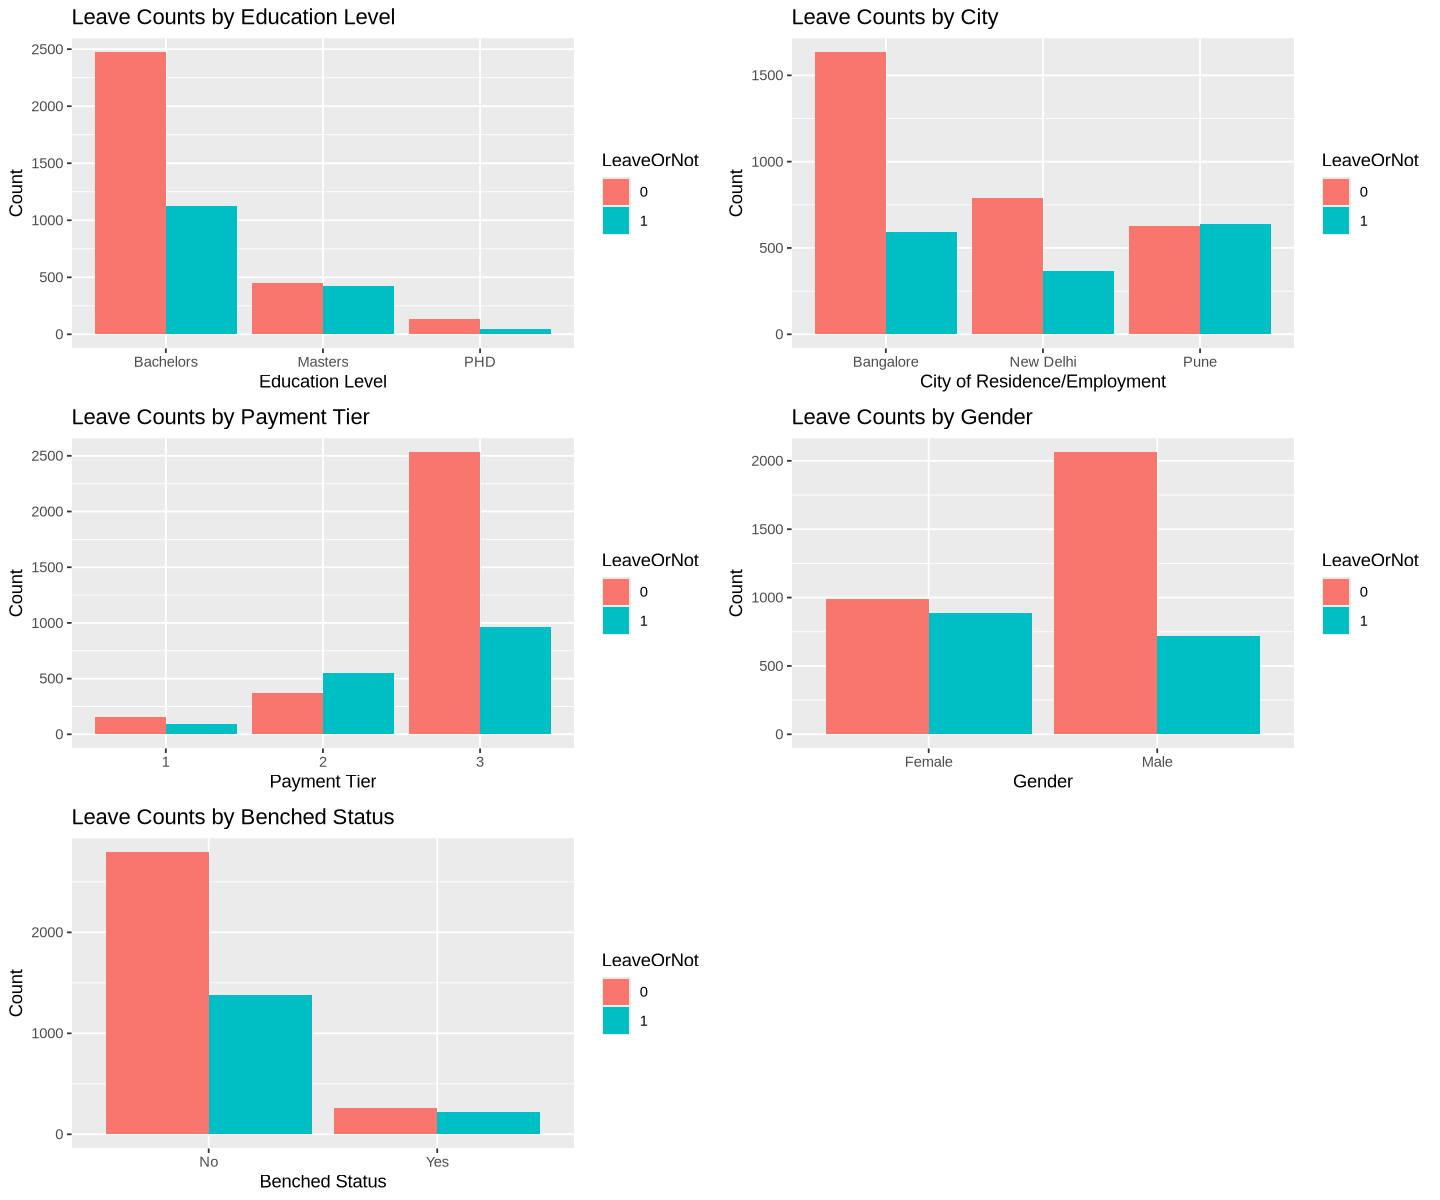

In [21]:
options(repr.plot.width=12, repr.plot.height=10)
grid.arrange(education_bar, city_bar, pay_bar, gender_bar, benched_bar)

From these plots we can make some observations. 

- First, most of the employees held Bachelors degrees, with a smaller portion holding Masters degrees and an even smaller portion holding PhDs. Employees with a Masters degree appeared to have a higher proportion of employees that left compared to the other groups. This difference could make Education a suitable predictor for leave status.
- Most of the employees lived in the city of Bangalore. The residents of Pune in particular seemed to have a higher proportion of employees leaving the company than the other two cities, making it possible that location could serve as a good predictor.
- Very few employees were in payment tier 1, with most being in tier 3. While employees in payment tiers 1 and 3 primarily stayed with the company, employees in payment tier 2 actually had a higher proportion of employees leave rather than stay. This indicates that payment tier could also be a good predictor.
- Somewhat more men were employed compared to women. A higher proportion of female employees left the company compared to men, which also points to gender potentially being a good predictor.
    - Note: there might be ethical considerations to be made about incuding gender (which depending on location, might be a protected hiring class) in a prediction problem like this one, to avoid unintentional discrimination. 
- Most employees had never been benched. Also, a higher proportion of employees that had been benched at some point left the company compared to employees that were never benched. The benched status of an employee could also be helpful for prediction.

Next, I'll also examine the 3 remaining continuous variables by constructing side-by-side boxplots, using whether the employee left on the x-axis and the numerical variable on the y-axis. This allows me to get a good sense for the spread/skew on the numerical variables while also seeing any differences between the employees that left.

In [22]:
age_box <- employee_dat %>%
ggplot(aes(x=LeaveOrNot, y = Age, fill = LeaveOrNot)) + 
    geom_boxplot() +
    labs(x = "Age (years)", y = "Count") +
    ggtitle("Side-by-side Boxplots of Age by Leave Status")

In [23]:
join_box <- employee_dat %>%
ggplot(aes(x=LeaveOrNot, y = JoiningYear, fill = LeaveOrNot)) + 
    geom_boxplot() +
    labs(x = "Join Year", y = "Count") +
    ggtitle("Side-by-side Boxplots of Join Year by Leave Status")

In [24]:
exp_box <- employee_dat %>%
ggplot(aes(x=LeaveOrNot, y = ExperienceInCurrentDomain, fill = LeaveOrNot)) + 
    geom_boxplot() +
    labs(x = "Experience in Current Domain (years)", y = "Count") +
    ggtitle("Side-by-side Boxplots of Experience by Leave Status")

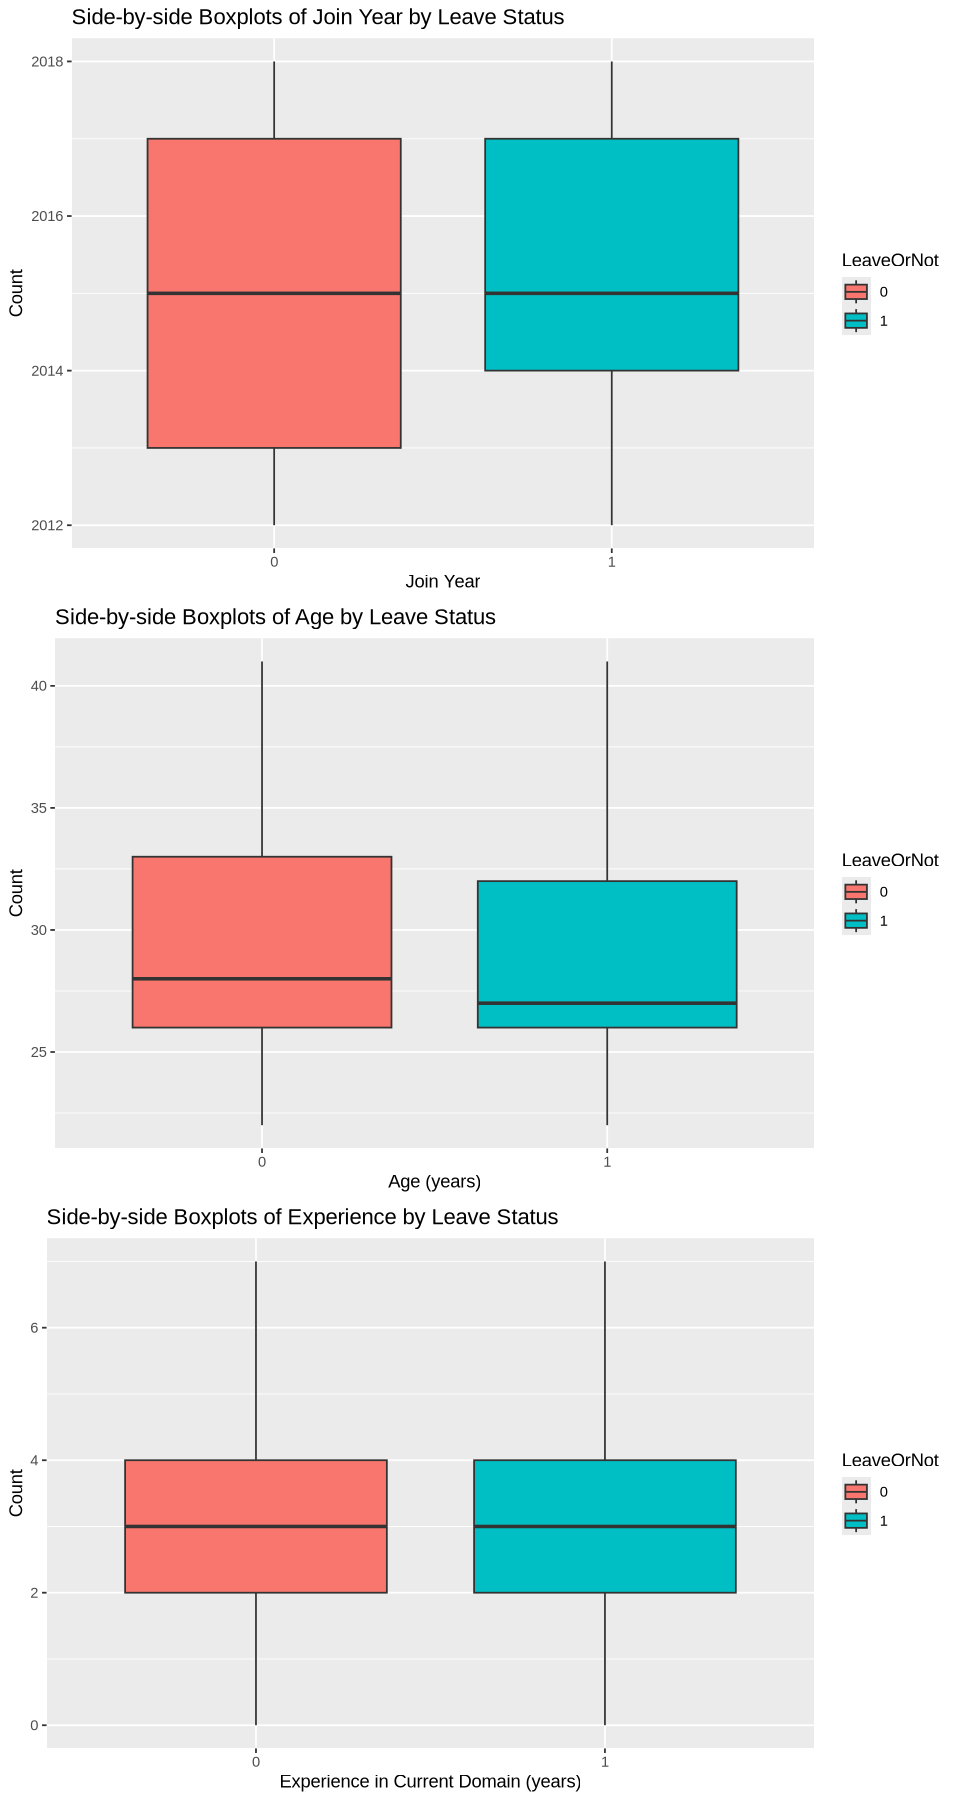

In [25]:
options(repr.plot.width=8, repr.plot.height=15)
grid.arrange(join_box, age_box, exp_box)

Compared to the categorical variables, the numerical variables seem to vary less between the employees that left versus the ones that didn't. 

- The median value (shown as the black bar) appears almost identical in all three of the plots when comparing the employees that stayed and left, though the median age of the employees that left was slightly lower than the ones that stayed.
- The 25th and 75th quantiles on the boxplots were fairly similar for all three of these side-by-side boxplots, though the 25th percentile of join year for people who left was slightly higher.
- The max and the min (excluding outliers, though there don't seem to be any -- somewhat expected given what the numerical variables are representing) on all three of these plots seem to be the same for employees that stayed and left.
- While the experience levels seem not to have much skew, the age (both of employees that left and the ones that didn't) is somewhat skewed (right skew), with more of the employees being younger. The employees that left appear are more skewed.
- There is a little skew (right skew) for the joining year of employees that left, indicating somewhat more joined earlier.

However, just looking at these plots doesn't tell us enough to decide on which variables to use, even if they give some sense about how the data looks. In my later analysis, I will perform variable selection to choose the best subset of variables for my model.

## Methods and Plan 

To address the research question (whether it is possible to accurately predict whether an employee will leave the company or not, based on data about the employee), I intend to construct a logistic regression model with Ridge regularization and assess its performance with appropriate classification metrics, including a plot of the ROC curve and a confusion matrix.

A logistic regression model is suitable for this dataset because the variable being predicted (`LeaveOrNot`) is a categorical variable with two levels. Using a logistic regression model also provides the odds (once transformed from the log-odds) of the employee leaving, which could potentially be useful in practical applications. Compared to more complex models, using a logistic model also makes it relatively straightforward to explain why the model made its predictions.

This model assumes that the relationship between the log-odds of the response are linear to the explanatory variables, that there is no hetereoscedacity, and that the data is independent. However, there are some potential issues. One issue is that there might not be a linear relationship between the log-odds of the target (`LeaveOrNot`) and the chosen subset of explanatory variables. If this is the case, the model may not yield good results even if other, more complex models (like K-nearest neighbours, random forests, gradient boosted trees etc.) capable of capturing non-linear relationships could. With an ordinary least-squares logistic regression, multicollinearity between the explanatory variables could be a concern, but this is somewhat addressed by the Ridge regularization (though it won't perform variable selection). 

Finally, there are some issues with the dataset itself. We do not know the year the data was collected, so we only have the join year but no information on how long the employee has been with the company, which could've been useful in prediction. Also, we aren't given any information on what each payment tier entails, and it could've been beneficial to treat the payment tier as an ordinal variable. Additionally, this binary classification model only predicts whether an employee will leave at this point in time (within a span of about a year). In practical applications an employer might be more interested in how long the employee will stay before leaving (survival analysis).

As part of the research question is assessing whether the logistic regression model is performing well, I will look at the test accuracy, confusion matrix and the ROC curve of the model. Notably, most of the employees stayed with the company (rather than leaving), with about 66% of the employees in the dataset recorded as staying in the company at the time of data collection. A model that predicts no employees ever leave the company would have an accuracy of around 66%, so I'd like to see the logistic regression perform better (i.e. at least 70%).

## Implementation of a proposed model

I'll start by splitting the data into a training and testing set.

In [26]:
set.seed(123)
employee_dat$id <- 1:nrow(employee_dat) # add a new ID column

# 70% into train split
employee_train <- 
    employee_dat %>% 
    slice_sample(prop = 0.7)

# 30% into test split
employee_test <- 
    employee_dat %>% 
    anti_join(employee_train, by = "id") 

# drop the ID column
employee_train <- 
    employee_train %>% 
    select(-id)

employee_test <-
    employee_test %>%
    select(-id)

head(employee_train, 5)
head(employee_test, 5)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Bachelors,2015,Pune,3,28,Male,No,1,0
Bachelors,2014,Bangalore,3,29,Male,No,1,0
Masters,2017,New Delhi,3,26,Male,No,4,1
Bachelors,2015,Bangalore,3,25,Male,No,3,0
Masters,2017,New Delhi,2,31,Male,No,4,0


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Bachelors,2016,Bangalore,3,22,Male,No,0,0
Bachelors,2016,Bangalore,3,34,Female,No,2,1
Masters,2017,New Delhi,2,37,Male,No,2,0
Bachelors,2016,Bangalore,3,39,Male,No,2,0


Next, I'll use cross-validation to find the best lambda to use in for the Ridge regularization. To do this, I have to first form the matrices that will be passed to `cv.glmnet`.

In [27]:
model_matrix_X_train <- 
    model.matrix(LeaveOrNot ~ ., employee_train)
model_matrix_X_train <- model_matrix_X_train[,-1]

matrix_Y_train <- 
    as.matrix(employee_train %>% select(LeaveOrNot), ncol = 1)

Now I can perform the cross-validation.

In [28]:
employee_cv_lambda_ridge <- 
  cv.glmnet(
       x = model_matrix_X_train, 
       y = matrix_Y_train,
       alpha = 0,
       family = "binomial",
       type.measure = "auc",
       nfolds = 10)

employee_cv_lambda_ridge


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

    Lambda Index Measure      SE Nonzero
min   0.01   100  0.7313 0.01035      11
1se 110.51     2  0.7225 0.01163      11

Here the $\hat{\lambda}_{\text{min}}$ is the value of $\hat{\lambda}$ that gave the highest average AUC in cross-validation, so we'll use that value in the model.

In [29]:
employee_ridge_max_AUC <- 
  glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  lambda = employee_cv_lambda_ridge$lambda.min
)

coef(employee_ridge_max_AUC)

12 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)               -361.80222684
EducationMasters             0.59466898
EducationPHD                 0.08283041
JoiningYear                  0.17993174
CityNew Delhi               -0.46870155
CityPune                     0.50088821
PaymentTier2                 0.49153196
PaymentTier3                -0.24690636
Age                         -0.03249241
GenderMale                  -0.79555833
EverBenchedYes               0.54868707
ExperienceInCurrentDomain   -0.06389274

Now, I'll use the results of this model to make the predictions (with the default threshold 0.5).

In [30]:
employee_class <- 
  predict(employee_ridge_max_AUC, model_matrix_X_train, type = "response") %>% round(0)
head(employee_class, 10)

,s0
1,0
2,0
3,0
4,0
5,0
6,0
7,1
8,0
9,1
10,0


Using these predictions, I can construct the confusion matrix for the training data.

In [31]:
employee_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(employee_class),
    reference = as.factor(employee_train$LeaveOrNot),
    positive = "1"
)

employee_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1934  691
         1  212  420
                                         
               Accuracy : 0.7228         
                 95% CI : (0.707, 0.7381)
    No Information Rate : 0.6589         
    P-Value [Acc > NIR] : 3.106e-15      
                                         
                  Kappa : 0.3117         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.3780         
            Specificity : 0.9012         
         Pos Pred Value : 0.6646         
         Neg Pred Value : 0.7368         
             Prevalence : 0.3411         
         Detection Rate : 0.1290         
   Detection Prevalence : 0.1940         
      Balanced Accuracy : 0.6396         
                                         
       'Positive' Class : 1              
                                         

The performance on the training set does seem to be somewhat better than it would have been if we'd just guessed that employees never left (since most of the employees in the dataset did not leave). This model seems to be getting somewhat more false negatives (Type II error) compared to false positives (Type I). We may be able to tweak this performance slightly by changing our threshold for predictions. 

Setting levels: control = 0, case = 1

Setting direction: controls < cases



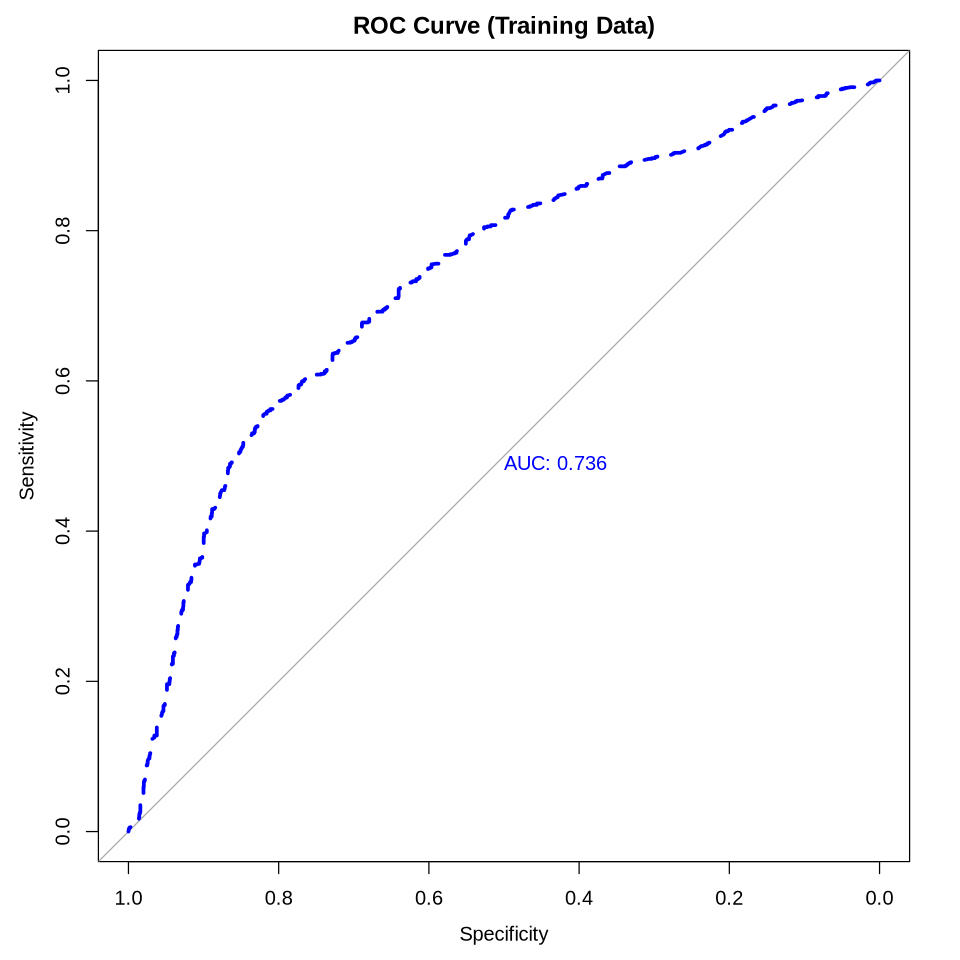

In [32]:
options(repr.plot.width = 8, repr.plot.height = 8)

ROC_ridge <- roc(
  response = employee_train$LeaveOrNot,
  predictor = predict(employee_ridge_max_AUC, newx = model_matrix_X_train)[,"s0"])

plot(ROC_ridge,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curve (Training Data)"
)

Let's also try to see what the best threshold might be from this curve.

In [33]:
best_threshold <- coords(ROC_ridge, "best")["threshold"] %>% pull()
best_threshold

[1] -0.3924

In [34]:
train_pred <- as.integer(predict(employee_ridge_max_AUC, newx = model_matrix_X_train, newy = matrix_Y_train) > best_threshold)

employee_confusion_matrix_adj <- 
    confusionMatrix(
    data = as.factor(train_pred),
    reference = as.factor(employee_train$LeaveOrNot),
    positive = "1"
)
employee_confusion_matrix_adj

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1761  495
         1  385  616
                                         
               Accuracy : 0.7298         
                 95% CI : (0.7142, 0.745)
    No Information Rate : 0.6589         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3842         
                                         
 Mcnemar's Test P-Value : 0.0002384      
                                         
            Sensitivity : 0.5545         
            Specificity : 0.8206         
         Pos Pred Value : 0.6154         
         Neg Pred Value : 0.7806         
             Prevalence : 0.3411         
         Detection Rate : 0.1891         
   Detection Prevalence : 0.3073         
      Balanced Accuracy : 0.6875         
                                         
       'Positive' Class : 1              
                                         

The altered threshold seems to have improved the performance slightly, but the primary effect is making the Type I and Type II errors more balanced. Now that we've seen the performance on the training data, let's see the performance on the test data.

In [35]:
# preparing the test matrices
model_matrix_X_test <- 
    model.matrix(LeaveOrNot ~ ., employee_test)
model_matrix_X_test <- model_matrix_X_test[,-1]

matrix_Y_test <- 
    as.matrix(employee_test %>% select(LeaveOrNot), ncol = 1)

In [36]:
test_pred <- as.integer(predict(employee_ridge_max_AUC, newx = model_matrix_X_test, newy = matrix_Y_test) > best_threshold)

employee_confusion_matrix_test <- 
    confusionMatrix(
    data = as.factor(test_pred),
    reference = as.factor(employee_test$LeaveOrNot),
    positive = "1"
)
employee_confusion_matrix_test

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 760 217
         1 147 272
                                          
               Accuracy : 0.7393          
                 95% CI : (0.7154, 0.7621)
    No Information Rate : 0.6497          
    P-Value [Acc > NIR] : 4.381e-13       
                                          
                  Kappa : 0.4076          
                                          
 Mcnemar's Test P-Value : 0.0002985       
                                          
            Sensitivity : 0.5562          
            Specificity : 0.8379          
         Pos Pred Value : 0.6492          
         Neg Pred Value : 0.7779          
             Prevalence : 0.3503          
         Detection Rate : 0.1948          
   Detection Prevalence : 0.3001          
      Balanced Accuracy : 0.6971          
                                          
       'Positive' Class : 1               
                              

For comparison, I'll also present the ROC curve of the test set.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



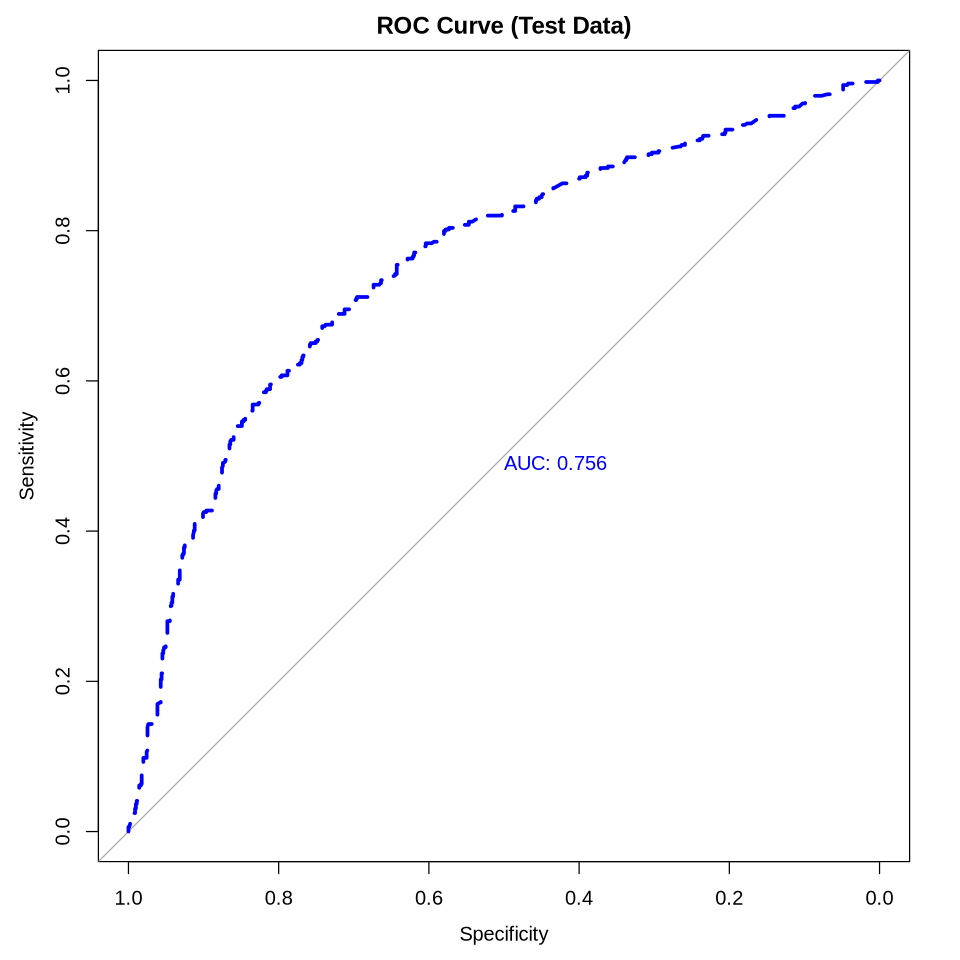

In [37]:
ROC_ridge <- roc(
  response = employee_test$LeaveOrNot,
  predictor = predict(employee_ridge_max_AUC,
                      newx = model_matrix_X_test )[,"s0"] )

plot(ROC_ridge,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curve (Test Data)"
)

While not directly relevant to the conclusion, it is a little interesting that the test accuracy was actually *higher* than the training accuracy. The model, then, is unlikely to be overfit.

While it is possible that the accuracy obtained with a more complex model capable of capturing non-linear relationships may be higher than this, with this relatively simple linear model we have already shown that results better than just predicting the most common class are possible. The logistic regression model with Ridge regularization was able to predict whether an employee will leave or not with 73.93% accuracy compared to simply predicting the most common class, which would have yielded an accuracy of 64.97%.